# Music Generation Using LSTM Neural Network

## Real World Problem

This case-study focuses on generating music automatically using Recurrent Neural Network(RNN).<br> 
We do not necessarily have to be a music expert in order to generate music. Even a non expert can generate a decent quality music using RNN.<br>
We all like to listen interesting music and if there is some way to generate music automatically, particularly decent quality music then it's a big leap in the world of music industry.<br><br>
<b>Task:</b>There are many fields where Neural Networks are showing commendable grown with impeccable results matching humans in performance.  Some of them are Image Recognition, Speech recognition, speech to text conversion. In this work I want to explore Music Generation using Character based RNN, there are already many kinds of implementations about music generation. I want to explore one kind of music generation which is least explored by others and demonstrate my findings.
<br><br>
Now, what is music? In short music is nothing but a sequence of musical notes. My input to the model is a sequence of musical events/notes and output will be new sequence of musical events/notes. In this case-study I have limited myself to single instrument music as this is my first cut model. In future, I will try to extend this to multiple instrument music. 

## Data Source:
1. http://trillian.mit.edu/~jc/music/book/oneills/1850/X/

In [2]:
def read_batches(all_chars, unique_chars):
    length = all_chars.shape[0]
    batch_chars = int(length / BATCH_SIZE) 
    
    for start in range(0, batch_chars - SEQ_LENGTH, 64):  #it denotes number of batches. It runs everytime when
        #new batch is created.
        X = np.zeros((BATCH_SIZE, SEQ_LENGTH))
        Y = np.zeros((BATCH_SIZE, SEQ_LENGTH, unique_chars))
        for batch_index in range(0, 16):  #it denotes each row in a batch.  
            for i in range(0, 64):  #it denotes each column in a batch. Each column represents each character means 
                #each time-step character in a sequence.
                X[batch_index, i] = all_chars[batch_index * batch_chars + start + i]
                Y[batch_index, i, all_chars[batch_index * batch_chars + start + i + 1]] = 1 #here I have added '1' because the
                #correct label will be the next character in the sequence. So, the next character will be denoted by
                #all_chars[batch_index * batch_chars + start + i + 1]
        yield X, Y

In [5]:
import os
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import matplotlib.pyplot as plt
data_directory = "/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data/"
data_file = "concat.txt"
charIndex_json = "char_to_index.json"
model_weights_directory = '/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data/Model_Weights_WithDropout_InitialData/'
BATCH_SIZE = 16
SEQ_LENGTH = 64
epochs=100
file = open(os.path.join(data_directory, data_file), mode = 'r')
data = file.read()
file.close()

char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(data))))}
print("Number of unique characters in our whole tunes database = {}".format(len(char_to_index))) #95

with open(os.path.join(data_directory, charIndex_json), mode = "w") as f:
    json.dump(char_to_index, f)
    
index_to_char = {i: ch for (ch, i) in char_to_index.items()}
unique_chars = len(char_to_index)
#model creation    
model = Sequential()

model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (BATCH_SIZE, SEQ_LENGTH))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(128, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(unique_chars)))

model.add(Activation("softmax"))
model.summary()

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

all_characters = np.asarray([char_to_index[c] for c in data], dtype = np.int32)
print("Total number of characters = "+str(all_characters.shape[0])) #781989

epoch_number, loss, accuracy = [], [], []
max_checks_without_progress = 5
checks_without_progress = 0
best_loss = np.infty
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    final_epoch_loss, final_epoch_accuracy = 0, 0
    epoch_number.append(epoch+1)
    
    for i, (x, y) in enumerate(read_batches(all_characters, unique_chars)):
        final_epoch_loss, final_epoch_accuracy = model.train_on_batch(x, y) 
    loss.append(final_epoch_loss)
    accuracy.append(final_epoch_accuracy)
    print("Loss: {}, Accuracy: {}".format(final_epoch_loss, final_epoch_accuracy))
    if loss[epoch] < best_loss:
        best_loss = loss[epoch]
        best_epoch=epoch
        check_without_progress = 0
    else:
        check_without_progress +=1
        print('Count for stopping {}'.format(check_without_progress))
        if check_without_progress > max_checks_without_progress:
            model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(best_epoch+1)))
            print('Saved Weights at epoch {} to file Weights_{}.h5'.format(best_epoch+1, best_epoch+1))
            print("Early stopping!")
            break 
    #saving weights after every 10 epochs
    if (epoch + 1) % 10 == 0:
        if not os.path.exists(model_weights_directory):
            os.makedirs(model_weights_directory)
        model.save_weights(os.path.join(model_weights_directory, "Weights_{}.h5".format(epoch+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(epoch+1, epoch+1))

#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Loss", "Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Loss"] = loss
log_frame["Accuracy"] = accuracy
log_frame.to_csv("/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data/log_WithDropout_InitialData.csv", index = False)


Number of unique characters in our whole tunes database = 95
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (16, 64, 512)             48640     
_________________________________________________________________
lstm_2 (LSTM)                (16, 64, 256)             787456    
_________________________________________________________________
dropout_2 (Dropout)          (16, 64, 256)             0         
_________________________________________________________________
lstm_3 (LSTM)                (16, 64, 128)             197120    
_________________________________________________________________
dropout_3 (Dropout)          (16, 64, 128)             0         
_________________________________________________________________
time_distributed_1 (TimeDist (16, 64, 95)              12255     
___________________________________________________________

50


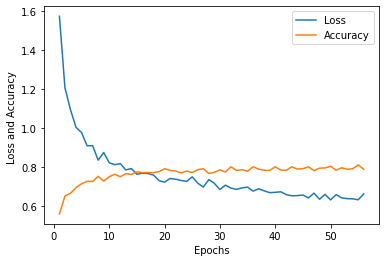

In [6]:
print(best_epoch+1)
plt.plot(epoch_number, loss, label='Loss')
plt.plot(epoch_number, accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy ')
plt.legend()
plt.show()
#50th epoch with 80.3 Accuracy

In [8]:
#Model2
import os
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
data_directory2 = "/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data2/"
data_file2 = "concat.txt"
charIndex_json2 = "char_to_index.json"
model_weights_directory2 = '/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data2/Model_Weights_WithDropout_InitialData/'
epochs=90
BATCH_SIZE = 16
SEQ_LENGTH = 64
file = open(os.path.join(data_directory2, data_file2), mode = 'r')
data2 = file.read()
file.close()
char_to_index = {ch: i for (i, ch) in enumerate(sorted(list(set(data2))))}
print("Number of unique characters in our whole tunes database = {}".format(len(char_to_index))) #87

with open(os.path.join(data_directory2, charIndex_json2), mode = "w") as f:
    json.dump(char_to_index, f)
    
index_to_char = {i: ch for (ch, i) in char_to_index.items()}
unique_chars = len(char_to_index)

#MOdel
model = Sequential()
   
model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (BATCH_SIZE, SEQ_LENGTH), name = "embd_1")) 

model.add(LSTM(256, return_sequences = True, stateful = True, name = "lstm_first"))
#model.add(Dropout(0.2, name = "drp_1"))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(TimeDistributed(Dense(unique_chars)))
model.add(Activation("softmax"))

model.load_weights("/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data/Model_Weights_WithDropout_InitialData/Weights_{}.h5".format(best_epoch+1), by_name = True)

adam=Adam(learning_rate=0.0001,clipnorm=1,name='adam')
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

all_characters = np.asarray([char_to_index[c] for c in data2], dtype = np.int32)
print("Total number of characters = "+str(all_characters.shape[0])) #155222

epoch_number, loss, accuracy = [], [], []
max_checks_without_progress = 5
checks_without_progress = 0
best_loss = np.infty
for epoch in range(epochs):
    print("Epoch {}/{}".format(epoch+1, epochs))
    final_epoch_loss, final_epoch_accuracy = 0, 0
    epoch_number.append(epoch+1)
    
    for i, (x, y) in enumerate(read_batches(all_characters, unique_chars)):
        final_epoch_loss, final_epoch_accuracy = model.train_on_batch(x, y)
    loss.append(final_epoch_loss)
    accuracy.append(final_epoch_accuracy)
    print("Loss: {}, Accuracy: {}".format(final_epoch_loss, final_epoch_accuracy))
    if loss[epoch] < best_loss:
      best_loss = loss[epoch]
      best_epoch2=epoch
      check_without_progress = 0
    else:
      check_without_progress +=1
      print('counting for early stopping {}'.format(check_without_progress))
      if check_without_progress > max_checks_without_progress:
        model.save_weights(os.path.join(model_weights_directory2, "Weights_{}.h5".format(best_epoch2+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(best_epoch2+1, best_epoch2+1))
        print("Early stopping!")
        break 
    #saving weights after every 10 epochs
    if (epoch + 1) % 10 == 0:
        if not os.path.exists(model_weights_directory2):
            os.makedirs(model_weights_directory2)
        model.save_weights(os.path.join(model_weights_directory2, "Weights_{}.h5".format(epoch+1)))
        print('Saved Weights at epoch {} to file Weights_{}.h5'.format(epoch+1, epoch+1))

#creating dataframe and record all the losses and accuracies at each epoch
log_frame = pd.DataFrame(columns = ["Epoch", "Loss", "Accuracy"])
log_frame["Epoch"] = epoch_number
log_frame["Loss"] = loss
log_frame["Accuracy"] = accuracy
log_frame.to_csv("/content/drive/MyDrive/Music-Generation-Using-Deep-Learning-master/Data2/log_WithDropout_InitialData.csv", index = False)


Number of unique characters in our whole tunes database = 95
Total number of characters = 781989
Epoch 1/90
Loss: 1.3718111515045166, Accuracy: 0.6005859375
Epoch 2/90
Loss: 1.0629819631576538, Accuracy: 0.689453125
Epoch 3/90
Loss: 0.9544500708580017, Accuracy: 0.7177734375
Epoch 4/90
Loss: 0.8860922455787659, Accuracy: 0.7373046875
Epoch 5/90
Loss: 0.8616089820861816, Accuracy: 0.734375
Epoch 6/90
Loss: 0.8024046421051025, Accuracy: 0.7626953125
Epoch 7/90
Loss: 0.7481006383895874, Accuracy: 0.765625
Epoch 8/90
Loss: 0.749495267868042, Accuracy: 0.7607421875
counting for early stopping 1
Epoch 9/90
Loss: 0.7363651990890503, Accuracy: 0.7744140625
Epoch 10/90
Loss: 0.7117217183113098, Accuracy: 0.7822265625
Saved Weights at epoch 10 to file Weights_10.h5
Epoch 11/90
Loss: 0.696391224861145, Accuracy: 0.775390625
Epoch 12/90
Loss: 0.6828992962837219, Accuracy: 0.7880859375
Epoch 13/90
Loss: 0.6656299829483032, Accuracy: 0.7783203125
Epoch 14/90
Loss: 0.634172260761261, Accuracy: 0.7998

55


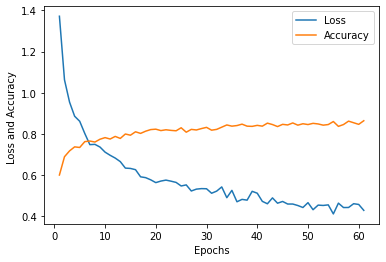

In [9]:
print(best_epoch2+1)
plt.plot(epoch_number, loss, label='Loss')
plt.plot(epoch_number, accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss and Accuracy ')
plt.legend()
plt.show()
#55-86.03% accuracy

## Music Generation
Block to load weights and generate music

In [7]:
#Music Generation
import os
import json
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
import matplotlib.pyplot as plt
data_directory = "./Music-Generation-Using-Deep-Learning-master/Data2/"
#data_file = "Test_result.txt"
charIndex_json = "char_to_index.json"
model_weights_directory = './Music-Generation-Using-Deep-Learning-master/Data2/Model_Weights_WithDropout_InitialData/'
BATCH_SIZE = 16
SEQ_LENGTH = 64

#ep = int(input("1. Which epoch number weight you want to load into the model(10, 20, 30, ..., 90). Small number will generate more errors in music: "))
ar = int(input("\n1. Enter any number between 0 to 86 which will be given as initial charcter to model for generating sequence: "))
ln = int(input("\n2. Enter the length of music sequence you want to generate. Typical number is between 300-600. Too small number will generate hardly generate any sequence: "))

with open(os.path.join(data_directory, charIndex_json)) as f:
    char_to_index = json.load(f)
index_to_char = {i:ch for ch, i in char_to_index.items()}
unique_chars = len(index_to_char)

model = Sequential()

model.add(Embedding(input_dim = unique_chars, output_dim = 512, batch_input_shape = (1,1))) 

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences = True, stateful = True))
model.add(Dropout(0.2))
model.add(LSTM(256,  stateful = True))
#I haven't given return_sequences = True because here I will give only one character to generate the
#sequence. In the end, I just have to get one output which is equivalent to getting output at the last time-stamp. So, here
#in last layer there is no need of giving return sequences = True.
model.add(Dropout(0.2))

model.add(Dense(unique_chars))
model.add(Activation("softmax"))
#model.summary()
model.load_weights(model_weights_directory + "Weights_{}.h5".format(55))
  
sequence_index = [ar]

for _ in range(ln):
    batch = np.zeros((1, 1))
    batch[0, 0] = sequence_index[-1]
    
    predicted_probs = model.predict_on_batch(batch).ravel()
    sample = np.random.choice(range(unique_chars), size = 1, p = predicted_probs)
    
    sequence_index.append(sample[0])

seq = ''.join(index_to_char[c] for c in sequence_index)

cnt = 0
for i in seq:
    cnt += 1
    if i == "\n":
        break
seq1 = seq[cnt:]
#above code is for ignoring the starting string of a generated sequence. This is because we are passing any arbitrary 
#character to the model for generating music. Now, the model start generating sequence from that character itself which we 
#have passed, so first few characters before "\n" contains meaningless word. Model start generating the music rhythm from
#next line onwards. The correct sequence it start generating from next line onwards which we are considering.


print(seq1)
print('########################################################')
#print(seq)





1. Enter any number between 0 to 86 which will be given as initial charcter to model for generating sequence: 30

2. Enter the length of music sequence you want to generate. Typical number is between 300-600. Too small number will generate hardly generate any sequence: 1000
A2 .B2.B2|(AGFE/F/) G2 cB|ABAG FD=D2|D4:|


X: 1246
T: Yealom The Wedding
M:C|
L:1/8
R:Reel
B:O'Neill's 1217
N:Collected by Ennis
Z:Transcribed by Trish O'Neil
K:Gmix
G>^G ((3G^^G) GA |
(B3) (AG) T(FGA) |B(TBAG) A2 ((3AGE)|GD G2 G2||
de|f3 a (ba)(gf)|(ea)(gf) (e^de)(dB)|(GBAG) (EA)AB|~G3 A G2 z|
c2 d^c g2 af|g2 f>e d3e|(d3g) (fed)|c2 A2 z2 z||
e|f2 {e}dB {^c}d2 d2|e4-e2 (f/g/a3/2g/)|Tf4 f2 (ag)|"(fg) (agfe) "ar"(dc)|(dc)(BA) (AG)(FE)|
D2 G2 G2 (cA)|"<"~ B3 d (c2 B2)|c3 d {d}c2 (BA)|G3 E E2 (CE)|
F2 (GA) (G3 E)|(D>CC) CD (ED) | D>EGA B2 A>G|A4 z2||
d>c|(~BAGF) G2 .D.D|.D.G,.G,.G, c,6 ||D2 (G>AGFED)|D2 D2 D2:|


X: 109
T: Jane's Heart Moon
N:"Moderate" "collected by J.O'Neill"
B:O'Neill's 106
Z:Transcribed by henrik.